# Querying data and building charts from Business Automation Insights data

This notebook shows how to retrieve and use data stored by Business Automation Insights for Business Automation Workflow. The notebook uses Spark SQL to retrieve process and task data and uses also pixiedust to display charts.

The notebook is configured to retrieve data from the HDFS data lake where Business Automation Insights stores that data. <strong>Specify the HDFS root path in the code below</strong>.

## Table Of Content
 
 + [Number of Completed Processes](#completeprocesses)
 + [Completed Processes By Applications](#completeprocessesperapp)
 + [Average Process Duration Per Application](#avgprocessdurationperapp)
 + [Average Duration of Processes in Minutes](#avgprocessduration)
 + [Total Number of Completed Activities](#totalcompleteactivities)
 + [Number of Completed Activities](#completeactivities)
 + [Average Duration per Activity](#avgactivityduration)
 + [Average Duration of Activities](#avgactivitydurationglobal)
 + [Completed Activities Per Users](#activitiesperuser)

First install PixieDust:

In [1]:
# !pip install -U --no-deps pixiedust
# !pip install -U --no-deps astunparse

Requirement already up-to-date: pixiedust in c:\programdata\anaconda3\lib\site-packages (1.1.18)
Requirement already up-to-date: astunparse in c:\programdata\anaconda3\lib\site-packages (1.6.3)


In [4]:
import pixiedust

Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [5]:
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import IntegerType

from datetime import datetime

hdfs_root = 'hdfs://namenode/user/bai'

<a id='completeprocesses'></a>
## Number of Completed Processes
This section extracts the completed processes from the BAI summaries data and displays the number of completed processes. The 'completed summary' data is covering both processes that are completed and the activities in a completed process. In HDFS, the data is stored as a set of JSON files. For a process, the information is stored within the following path:

<pre>
[root-directory]/ibm-bai/bpmn-summaries-completed/[process application id]/[process application version id]/process/[process id]/[date]
</pre>
In the code below we use wildcard (\*) to read all the json data for all process applications and all processes. Please refer to the BAI documentation to learn how to use the IBM BPM REST API to retrieve the process application ids and versions.



In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark.conf.set("dfs.client.use.datanode.hostname", "true")

summaries = spark.read.json(hdfs_root +'/ibm-bai/bpmn-summaries-completed/*/*/process/*/*')

print ('The data contains ' + str(summaries.count()) + ' completed process')

The data contains 15 completed process


In [7]:
from  pyspark.sql.functions import col

summaries = summaries.withColumn("duration_in_minutes", col("duration")/60000)
summaries.createOrReplaceTempView("bpmnSummaries")

summaries.cache();

<a id='completeprocessesperapp'></a>

## Completed Processes By Applications
This section uses the summary data for completed processes to display the number of completed processes for each process application.

In [ ]:
display(summaries)

With Spark SQL, you can use:

In [10]:
spark.sql("select processApplicationName, count(id) from bpmnSummaries group by processApplicationName").show()

+----------------------+---------+
|processApplicationName|count(id)|
+----------------------+---------+
|         RetailBanking|        1|
|         Hiring Sample|        1|
|       Risk Assessment|        2|
|  Mortgage Application|       11|
+----------------------+---------+



<a id='avgprocessdurationperapp'></a>
## Average Process Duration Per Application
This sections uses the summary data for completed processes to display the average process duration in minutes for each process application. It uses the 'duration' property of the 'completed process' data.

In [ ]:
display(summaries)

With Spark SQL, you can use:

In [12]:
spark.sql("select name, avg(duration_in_minutes) from bpmnSummaries group by name").show()

+--------------------+------------------------+
|                name|avg(duration_in_minutes)|
+--------------------+------------------------+
|Review Mortgage A...|       5.589466666666667|
|         Cancel Case|    0.013266666666666666|
|Check Land Registrar|    0.001072222222222...|
|Perform Final Review|     0.17411666666666667|
|      Review Payslip|      1.8568583333333333|
|Standard HR Open ...|     0.36906666666666665|
|Perform Risk Asse...|    0.030841666666666667|
|   Supervisor Review|      113339.42936666666|
+--------------------+------------------------+



<a id='avgprocessduration'></a>
## Average Duration of Processes in Minutes
This section uses the summary data for completed processes to display the average duration of each process.

In [13]:
spark.sql("select avg(duration_in_minutes) from bpmnSummaries").show()

+------------------------+
|avg(duration_in_minutes)|
+------------------------+
|       7557.380463333333|
+------------------------+



<a id='totalcompleteactivities'></a>
## Number of Completed Activities
Reading activity information is similar to reading the process information. The path in HDFS is similar:
<pre> [root-directory]/ibm-bai/bpmn-summaries-completed/workflow/[process application id]/[process application version id]/activity/[process id]/[activity id]/[date]</pre>
    
The code lines below read all the completed activities by using wildcards in the path, then display the number of activities.

In [14]:
activitysummaries = spark.read.json(hdfs_root + "/ibm-bai/bpmn-summaries-completed/*/*/activity/*/*/*")
activitysummaries = activitysummaries.withColumn("duration_in_minutes", col("duration")/60000)
activitysummaries.createOrReplaceTempView("activitysummaries")

activitysummaries.cache();

In [15]:
print ('The data containts ' + str(activitysummaries.count()) + ' completed activities')

The data containts 17 completed activities


<a id='completeactivities'></a>

## Number Of Completed Activities
This section displays the number of completed activities per activity type.

In [ ]:
display(activitysummaries)

With Spark SQL, you can use:

In [23]:
spark.sql("select name, count(*) from activitysummaries group by name").show()

+--------------------+--------+
|                name|count(1)|
+--------------------+--------+
|      Process 1 Task|      43|
|Submit position r...|      51|
|      Process 2 Task|      34|
|Find position can...|      45|
|    Top Service Flow|      29|
|     Process 1 AdHoc|      33|
|       Top User Task|      24|
|Review new positi...|      47|
|Nested Tkt Servic...|      75|
|Nested Linked Pro...|      25|
|          Subprocess|      25|
|    Nested User Task|      75|
|Notify hiring man...|       2|
|Recursive Linked ...|      50|
|      Confirm Launch|      30|
|Send escalation n...|       3|
|    Launch Process 2|      30|
+--------------------+--------+



<a id='avgactivityduration'></a>
## Average Duration per Activity
In this section, the average duration is displayed per activity.


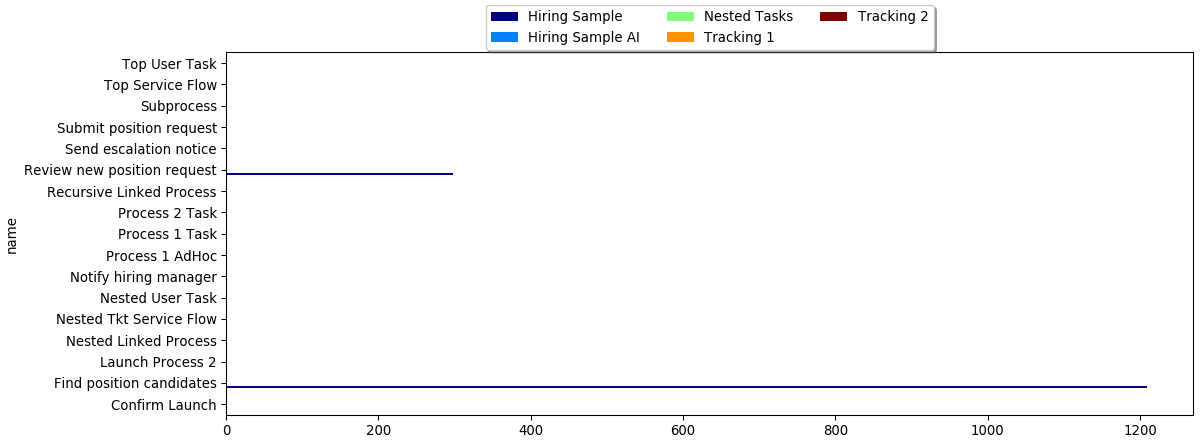

In [24]:
display(activitysummaries)

In Spark SQL, you can use:

In [25]:
spark.sql("select name, avg(duration_in_minutes) from activitysummaries group by name").show()

+--------------------+------------------------+
|                name|avg(duration_in_minutes)|
+--------------------+------------------------+
|      Process 1 Task|       0.126568992248062|
|Submit position r...|     0.26271666666666665|
|      Process 2 Task|      0.7160607843137256|
|Find position can...|      1182.6352514814814|
|    Top Service Flow|    0.002838505747126437|
|     Process 1 AdHoc|      0.5841707070707071|
|       Top User Task|     0.12280416666666667|
|Review new positi...|      291.98195780141845|
|Nested Tkt Servic...|    0.003866000000000...|
|Nested Linked Pro...|     0.15618266666666666|
|    Nested User Task|      0.1504744444444444|
|          Subprocess|     0.16426400000000002|
|Notify hiring man...|                     0.0|
|Recursive Linked ...|     0.23234800000000003|
|      Confirm Launch|                0.559535|
|Send escalation n...|    0.006566666666666666|
|    Launch Process 2|    0.002039444444444444|
+--------------------+------------------

<a id='avgactivitydurationglobal'></a>
## Average Duration of Activities
This section computes the average duration of all the activities.

In [26]:
spark.sql("select avg(duration_in_minutes) from activitysummaries").show()

+------------------------+
|avg(duration_in_minutes)|
+------------------------+
|      107.97955507246377|
+------------------------+



<a id='activitiesperuser'></a>
## Completed Activities By Users
This section displays the activities that are completed by the various individuals or teams.


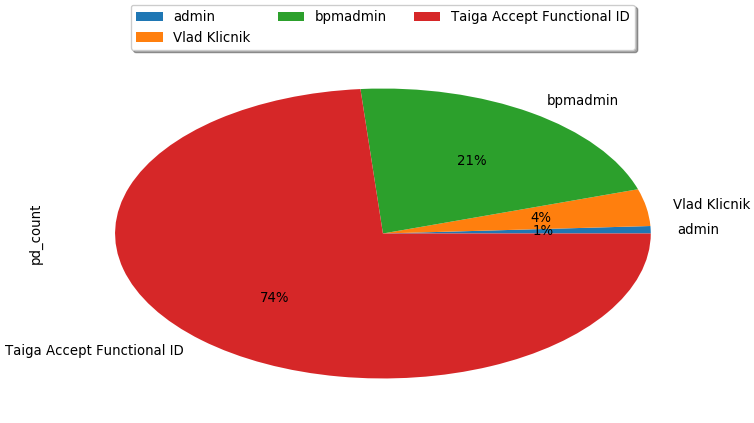

In [27]:
display(activitysummaries)

With Spark SQL, you can use:

In [28]:
spark.sql("select performerName, count(*) from activitysummaries group by performerName").show()

+--------------------+--------+
|       performerName|count(1)|
+--------------------+--------+
|Taiga Accept Func...|     358|
|                null|     135|
|            bpmadmin|     104|
|        Vlad Klicnik|      20|
|               admin|       4|
+--------------------+--------+



Author: Emmanuel Tissandier is a Senior Technical Staff Member and architect in the Business Automation team in the IBM France Lab.